# ORDINAL REGRESSION

## Load libraries

In [1]:
import arviz as az
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import warnings

import bambi as bmb

warnings.filterwarnings("ignore", category=FutureWarning)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Load data

In [2]:
trolly = pd.read_csv("https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Trolley.csv", sep=";")
trolly = trolly[["response", "action", "intention", "contact"]]
trolly["action"] = pd.Categorical(trolly["action"], ordered=False)
trolly["intention"] = pd.Categorical(trolly["intention"], ordered=False)
trolly["contact"] = pd.Categorical(trolly["contact"], ordered=False)
trolly["response"] = pd.Categorical(trolly["response"], ordered=True)

In [3]:
# 7 ordered categories from 1-7
trolly.response.unique()

[4, 3, 5, 2, 1, 7, 6]
Categories (7, int64): [1 < 2 < 3 < 4 < 5 < 6 < 7]

## Intercept only model

In [5]:
pr_k = trolly.response.value_counts().sort_index().values / trolly.shape[0]

In [18]:
pr_k

array([0.12829809, 0.09154079, 0.10785498, 0.23393756, 0.14723061,
       0.14551863, 0.14561934])

In [19]:
cum_pr_k = np.cumsum(pr_k)
cum_pr_k

array([0.12829809, 0.21983887, 0.32769386, 0.56163142, 0.70886203,
       0.85438066, 1.        ])

In [20]:
logit_func = lambda x: np.log(x / (1 - x))
cum_logit = logit_func(cum_pr_k)
cum_logit

C:\Users\bacos1\AppData\Local\Temp\ipykernel_5944\1929668909.py:1: RuntimeWarning: invalid value encountered in log
  logit_func = lambda x: np.log(x / (1 - x))


array([-1.91609116, -1.26660559, -0.718634  ,  0.24778573,  0.88986365,
        1.76938091,         nan])

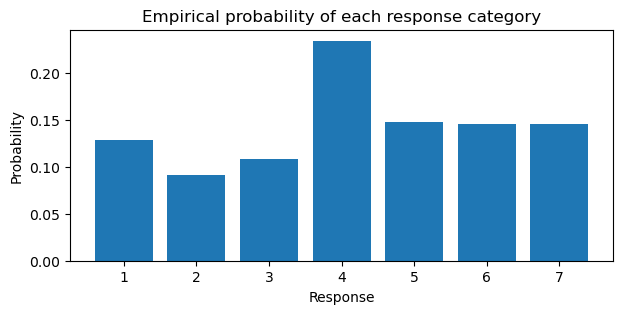

In [7]:
plt.figure(figsize=(7, 3))
plt.bar(np.arange(1, 8), pr_k)
plt.ylabel("Probability")
plt.xlabel("Response")
plt.title("Empirical probability of each response category");

## First model

In [8]:
model = bmb.Model(
                    "response ~ 0",
                    data = trolly,
                    family = 'cumulative'
)

In [10]:
idata = model.fit(random_seed = 1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [response_threshold]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.


In [11]:
model

       Formula: response ~ 0
        Family: cumulative
          Link: p = logit
  Observations: 9930
        Priors: 
    target = p
        
        
        Auxiliary parameters
            threshold ~ Normal(mu: [-2.  -1.2 -0.4  0.4  1.2  2. ], sigma: 1.0, transform: ordered)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [12]:
az.summary(idata)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
response_threshold[0] -1.917  0.030  -1.973   -1.861        0.0      0.0   
response_threshold[1] -1.267  0.024  -1.312   -1.221        0.0      0.0   
response_threshold[2] -0.719  0.021  -0.759   -0.678        0.0      0.0   
response_threshold[3]  0.248  0.020   0.210    0.286        0.0      0.0   
response_threshold[4]  0.890  0.022   0.847    0.930        0.0      0.0   
response_threshold[5]  1.771  0.028   1.715    1.822        0.0      0.0   

                       ess_bulk  ess_tail  r_hat  
response_threshold[0]    4227.0    3176.0    1.0  
response_threshold[1]    4754.0    3581.0    1.0  
response_threshold[2]    5284.0    3229.0    1.0  
response_threshold[3]    4945.0    3394.0    1.0  
response_threshold[4]    5373.0    3444.0    1.0  
response_threshold[5]    5612.0    3587.0    1.0

In [13]:
expit_func = lambda x: 1 / (1 + np.exp(-x))
cumprobs = expit_func(idata.posterior.response_threshold).mean(("chain", "draw"))
cumprobs = np.append(cumprobs, 1)

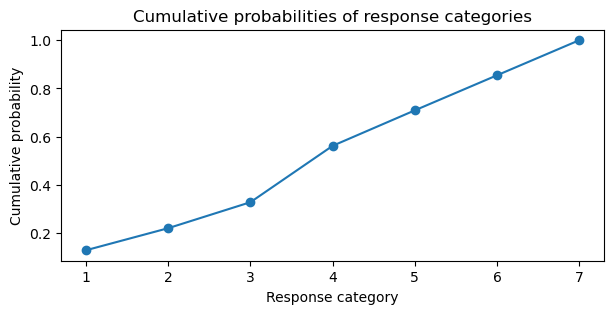

In [14]:
plt.figure(figsize=(7, 3))
plt.plot(sorted(trolly.response.unique()), cumprobs, marker='o')
plt.ylabel("Cumulative probability")
plt.xlabel("Response category")
plt.title("Cumulative probabilities of response categories");

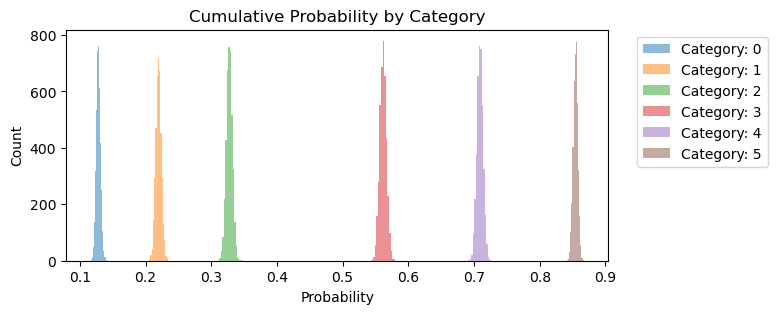

In [15]:
fig, ax = plt.subplots(figsize=(7, 3))
for i in range(6):
    outcome = expit_func(idata.posterior.response_threshold).sel(response_threshold_dim=i).to_numpy().flatten()
    ax.hist(outcome, bins=15, alpha=0.5, label=f"Category: {i}")
ax.set_xlabel("Probability")
ax.set_ylabel("Count")
ax.set_title("Cumulative Probability by Category")
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left");

In [16]:
# derivative
ddx = np.diff(cumprobs)
probs = np.insert(ddx, 0, cumprobs[0])

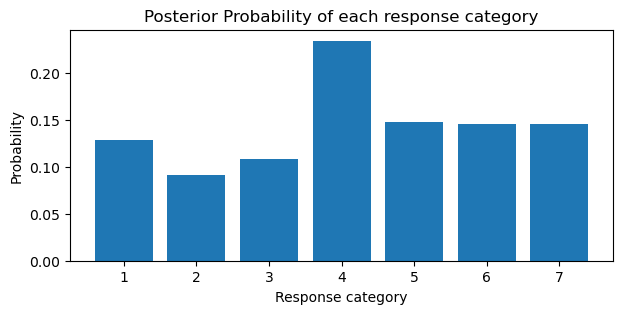

In [17]:
plt.figure(figsize=(7, 3))
plt.bar(sorted(trolly.response.unique()), probs)
plt.ylabel("Probability")
plt.xlabel("Response category")
plt.title("Posterior Probability of each response category");

## Adding predictors

In [21]:
model = bmb.Model(
                    "response ~ 0 + action + intention + contact + action:intention + contact:intention",
                    data=trolly, 
                    family="cumulative"
)

In [22]:
idata = model.fit(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [response_threshold, action, intention, contact, action:intention, contact:intention]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 225 seconds.


In [23]:
az.summary(
    idata, 
    var_names=["action", "intention", "contact", 
               "action:intention", "contact:intention"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
action[1]               -0.463  0.055  -0.569   -0.364      0.001    0.001   
intention[1]            -0.272  0.059  -0.382   -0.165      0.001    0.001   
contact[1]              -0.323  0.070  -0.449   -0.188      0.001    0.001   
action:intention[1, 1]  -0.458  0.082  -0.615   -0.312      0.002    0.001   
contact:intention[1, 1] -1.283  0.099  -1.468   -1.103      0.002    0.001   

                         ess_bulk  ess_tail  r_hat  
action[1]                  2211.0    2704.0    1.0  
intention[1]               2068.0    2714.0    1.0  
contact[1]                 2569.0    3007.0    1.0  
action:intention[1, 1]     2233.0    2751.0    1.0  
contact:intention[1, 1]    2585.0    2687.0    1.0

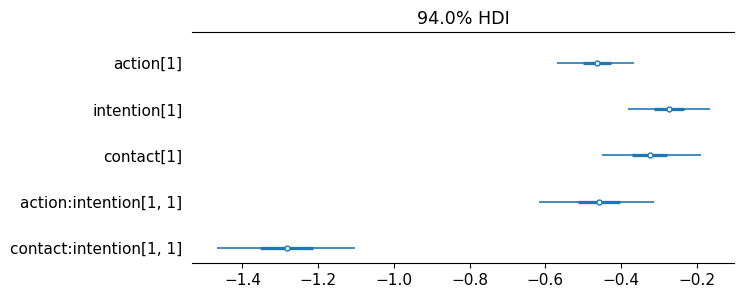

In [24]:
az.plot_forest(
    idata,
    combined=True,
    var_names=["action", "intention", "contact", 
               "action:intention", "contact:intention"],
    figsize=(7, 3),
    textsize=11
);

## Posterior predictive distribution

In [25]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], c[1] * amount, c[2])

def plot_ppc_discrete(idata, bins, ax):
    
    def add_discrete_bands(x, lower, upper, ax, **kwargs):
        for i, (l, u) in enumerate(zip(lower, upper)):
            s = slice(i, i + 2)
            ax.fill_between(x[s], [l, l], [u, u], **kwargs)

    var_name = list(idata.observed_data.data_vars)[0]
    y_obs = idata.observed_data[var_name].to_numpy()
    
    counts_list = []
    for draw_values in az.extract(idata, "posterior_predictive")[var_name].to_numpy().T:
        counts, _ = np.histogram(draw_values, bins=bins)
        counts_list.append(counts)
    counts_arr = np.stack(counts_list)

    qts_90 = np.quantile(counts_arr, (0.05, 0.95), axis=0)
    qts_70 = np.quantile(counts_arr, (0.15, 0.85), axis=0)
    qts_50 = np.quantile(counts_arr, (0.25, 0.75), axis=0)
    qts_30 = np.quantile(counts_arr, (0.35, 0.65), axis=0)
    median = np.quantile(counts_arr, 0.5, axis=0)

    colors = [adjust_lightness("C0", x) for x in [1.8, 1.6, 1.4, 1.2, 0.9]]

    add_discrete_bands(bins, qts_90[0], qts_90[1], ax=ax, color=colors[0])
    add_discrete_bands(bins, qts_70[0], qts_70[1], ax=ax, color=colors[1])
    add_discrete_bands(bins, qts_50[0], qts_50[1], ax=ax, color=colors[2])
    add_discrete_bands(bins, qts_30[0], qts_30[1], ax=ax, color=colors[3])

    
    ax.step(bins[:-1], median, color=colors[4], lw=2, where="post")
    ax.hist(y_obs, bins=bins, histtype="step", lw=2, color="black", align="mid")
    handles = [
        Line2D([], [], label="Observed data", color="black", lw=2),
        Line2D([], [], label="Posterior predictive median", color=colors[4], lw=2)
    ]
    ax.legend(handles=handles)
    return ax

In [27]:
idata_pps = model.predict(idata=idata, kind="pps", inplace=False)

In [ ]:
bins = np.arange(7)
fig, ax = plt.subplots(figsize=(7, 3))
ax = plot_ppc_discrete(idata_pps, bins, ax)
ax.set_xlabel("Response category")
ax.set_ylabel("Count")
ax.set_title("Cumulative model - Posterior Predictive Distribution");

## Sequential model

In [34]:
attrition = pd.read_csv("C:/Users/bacos1/Documents/Python/per_python_bayes/Bambi/WA_Fn-UseC_-HR-Employee-Attrition.csv")

In [35]:
attrition.head()

Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...                         1            80                 0   
1  ...                         4            80                 1   
2  ...                         2            80                 0   
3  ...                         3            80                 0   
4  ...                         4            80                 1   

   TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                  8                      0               1               6   
1                 10                      3               3              10   
2                  7                      3               3               0   
3                  8                      3               3               8   
4                  6                      3               3               2   

  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
0                  4                        0                     5  
1                  7                        1                     7  
2                  0                        0                     0  
3                  7                        3                     0  
4                  2                        2                     2  

[5 rows x 35 columns]

In [37]:
attrition = attrition[attrition["Attrition"] == "No"]
attrition["YearsAtCompany"] = pd.Categorical(attrition["YearsAtCompany"], ordered=True)
attrition[["YearsAtCompany", "Age"]].head()

YearsAtCompany  Age
1             10   49
3              8   33
4              2   27
5              7   32
6              1   59

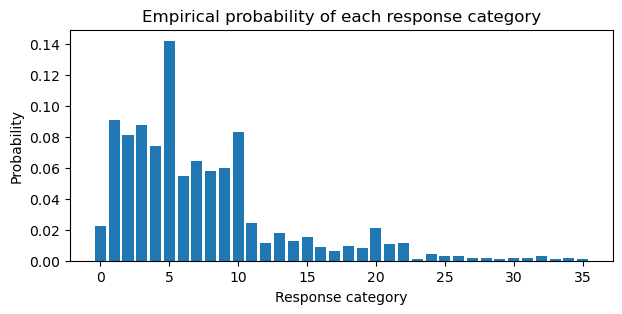

In [38]:
pr_k = attrition.YearsAtCompany.value_counts().sort_index().values / attrition.shape[0]

plt.figure(figsize=(7, 3))
plt.bar(np.arange(0, 36), pr_k)
plt.xlabel("Response category")
plt.ylabel("Probability")
plt.title("Empirical probability of each response category");

In [39]:
sequence_model = bmb.Model(
    "YearsAtCompany ~ 0 + TotalWorkingYears", 
    data=attrition, 
    family="sratio"
)
sequence_idata = sequence_model.fit(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [YearsAtCompany_threshold, TotalWorkingYears]


ValueError: Not enough samples to build a trace.